# Trabajo Práctico 2: Análisis con LightGBM - Organización de Datos

**Alumnos y Padrón**

    - Enrique, Alvaro Castro - 103991
    - Ivan, Conde - 102497
    - Luizaga, Ricardo - 87528

## Importamos las bibiliotecas necesarias

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from lightgbm import LGBMClassifier
import import_ipynb
from FuncionesAux import *

importing Jupyter notebook from FuncionesAux.ipynb


## Importamos los datos y los preprocesamos

**Leemos los datos que tenemos y llamamos a las funciones que se encargarán de dejar listos los datasets.**

In [2]:
train_values,train_labels = obtenerDataTrain()
train_values_subset = prepararDataSet(train_values)
train_values_subset = dummyEncoding(train_values_subset)

# Boosting

En boosting se entrena un primer modelo sobre todo el set de entrenamiento. Luego se entrenan modelos subsiguientes a partir de los datos que el modelo anterior predijo mal. De esta forma la varianza total del ensamble es baja, porque cada modelo entrenado ponderará de forma distinta las observaciones. En general los ensambles tienen bajo sesgo, y en particular boosting logra bajar la varianza. 

A cada instancia se le asigna inicialmente un peso, luego se predice y se recalculan los pesos, restandole importancia a las bien clasificadas para entrenar al modelo siguiente.

## LightGBM

##### Dividimos el set de datos en sets de training y test

In [3]:
X_train, X_test, y_train, y_test = train_test_split(train_values_subset.values,train_labels.values.ravel())

#### Expandimos el data set:

In [4]:
train_values_subset = expandirDataSet(train_values_subset)

##### Dividimos el set de datos expandido en sets de training y test

In [5]:
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(train_values_subset.values,train_labels.values.ravel())

### Buscamos los mejores parámetros

##### Buscamos los mejores parametros para el dataset base

In [6]:
params = [
    {
        'n_estimators': [50, 100, 150, 250],
        'num_leaves' : [30, 50, 70, 100, 200],
        'learning_rate' : [0.1],
        'max_depth' : [4, 7, 9, 12],
        'objective': ['binary', 'multiclass'],
    },
]

boostingBase = LGBMClassifier()
gridBase = GridSearchCV(boostingBase, params, n_jobs=-1)
gridBase.fit(X_train, y_train)

acc = gridBase.score(X_train, y_train)
print("[INFO] grid search accuracy: {:.2f}%".format(acc * 100))
print("[INFO] grid search best parameters: {}".format(gridBase.best_params_))

[INFO] grid search accuracy: 81.62%
[INFO] grid search best parameters: {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 250, 'num_leaves': 200, 'objective': 'binary'}


##### Buscamos los mejores parametros para el dataset expandido

In [7]:
params = [
    {
        'n_estimators': [50, 100, 150, 250],
        'num_leaves' : [30, 50, 70, 100, 200],
        'learning_rate' : [0.1],
        'max_depth' : [4, 7, 9, 12],
        'objective': ['binary', 'multiclass'],
    },
]

boostingExp = LGBMClassifier()
gridExp = GridSearchCV(boostingExp, params, n_jobs=-1)
gridExp.fit(X_train, y_train)

acc = gridExp.score(X_train, y_train)
print("[INFO] grid search accuracy: {:.2f}%".format(acc * 100))
print("[INFO] grid search best parameters: {}".format(gridExp.best_params_))

[INFO] grid search accuracy: 81.62%
[INFO] grid search best parameters: {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 250, 'num_leaves': 200, 'objective': 'binary'}


### Evaluamos las métricas

##### Utilizando el dataset base

In [8]:
boostingBase = LGBMClassifier(num_leaves=gridBase.best_params_["num_leaves"], \
                       max_depth=gridBase.best_params_["max_depth"],learning_rate=gridBase.best_params_["learning_rate"], \
                       n_estimators=gridBase.best_params_["n_estimators"], objective=gridBase.best_params_["objective"])
boostingBase.fit(X_train, y_train)
preds = boostingBase.predict(X_test)
f1_score(y_test, preds, average='micro')

0.7411705115807893

##### Utilizando el dataset expandido

In [9]:
boostingExp = LGBMClassifier(num_leaves=gridExp.best_params_["num_leaves"], \
                       max_depth=gridExp.best_params_["max_depth"],learning_rate=gridExp.best_params_["learning_rate"], \
                       n_estimators=gridExp.best_params_["n_estimators"], objective=gridExp.best_params_["objective"])
boostingExp.fit(X_train_exp, y_train_exp)
preds = boostingExp.predict(X_test_exp)
f1_score(y_test_exp, preds, average='micro')

0.7434728553667633

## Predicciones sobre el nuevo archivo

Obtenemos y preparamos el nuevo archivo realizando el mismo preprocesamiento hecho anteriormente.

Dado que obtuvimos mejores resultados utilizando el boosting que utiliza el dataset expandido y con los parametros encontrados mediante  Gridsearch será este el que utilizaremos para predecir sobre el nuevo archivo.

In [10]:
test_values = obtenerDataTest()
test_values_subset = prepararDataSet(test_values)
test_values_subset = dummyEncoding(test_values_subset)
test_values_subset = expandirDataSet(test_values_subset)

In [11]:
predictions = boostingExp.predict(test_values_subset)

In [12]:
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission.to_csv('submission.csv')

Text(0.5, 0, 'LightGBM Feature Importance')

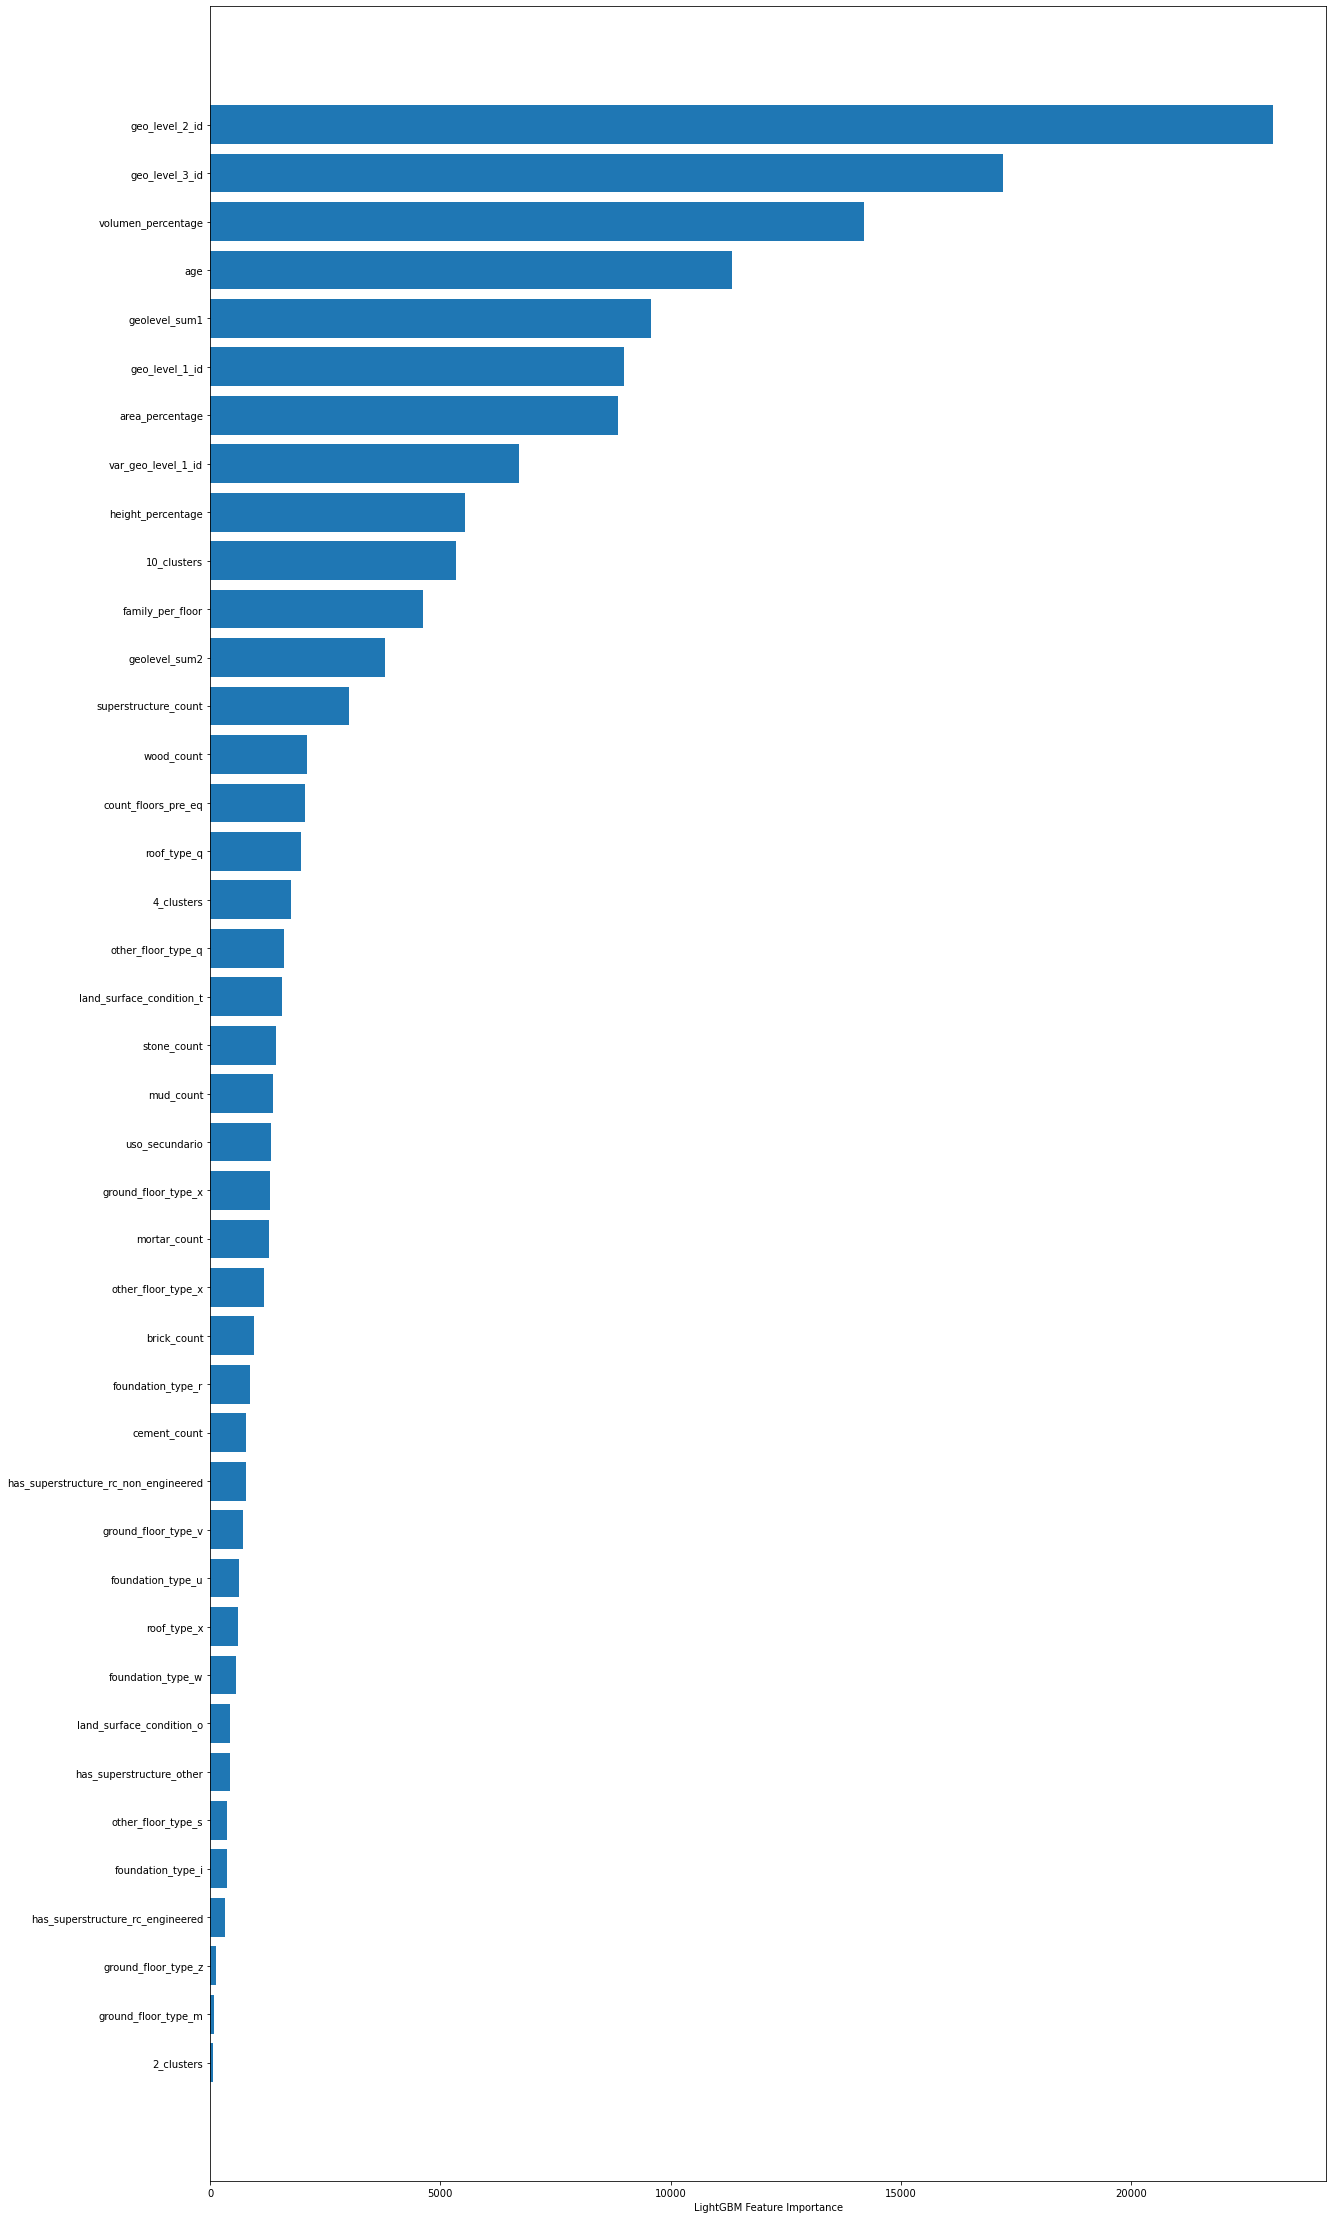

In [13]:
plt.figure(figsize=(20,40))
sorted_idx = boostingExp.feature_importances_.argsort()
plt.barh(train_values_subset.columns[sorted_idx], boostingExp.feature_importances_[sorted_idx])
plt.xlabel("LightGBM Feature Importance")